In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as RectPatch

from ccn import Constraint, ConstraintsGroup, ConstraintsLayer, train, test, draw_classes

### Define the dataset

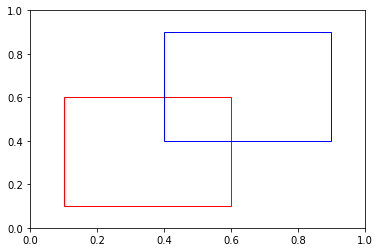

In [2]:
class Rectangle:
    def __init__(self, x0, x1, y0, y1):
        self.lower = np.array([x0, y0])
        self.higher = np.array([x1, y1])
        
    def inside(self, x, y):
        point = np.array([x, y])
        return ((self.lower <= point) * (point <= self.higher)).sum().item() == 2
    
    def plot(self, ax, edgecolor = 'blue'):
        dim = self.higher - self.lower
        ax.add_patch(RectPatch((self.lower[0], self.lower[1]), dim[0], dim[1], fill = False, edgecolor = edgecolor))
    
rect0 = Rectangle(0.1, 0.6, 0.1, 0.6)
rect1 = Rectangle(0.4, 0.9, 0.4, 0.9)

def draw_rectangles(ax, rect0, rect1):
    plt.axis([0., 1., 0., 1.])
    rect0.plot(ax, 'red')
    rect1.plot(ax)

fig, ax = plt.subplots()
draw_rectangles(ax, rect0, rect1)
plt.show()

In [3]:
class RectanglesDataset(Dataset):
    def __init__(self, count, r0, r1):
        super(RectanglesDataset, self).__init__()
        self.r0 = r0
        self.r1 = r1

        self.values = [torch.rand((2,)) for i in range(count)]
        self.labels = [self.correct(x, y) for (x, y) in self.values]

    def correct(self, x, y):
        small = self.r0.inside(x, y)
        big = small or self.r1.inside(x, y)
        return torch.tensor([1. if v else 0. for v in [small, big]])

    def __len__(self):
        return len(self.values)  

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [4]:
points = 10000
train_data = RectanglesDataset(points, rect0, rect1)
test_data = RectanglesDataset(points // 10, rect0, rect1)

train_dataloader = DataLoader(train_data, batch_size = 64)
test_dataloader = DataLoader(test_data, batch_size = 64)

### Define the neural network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### Training and testing

In [6]:
clayer = ConstraintsLayer(ConstraintsGroup([Constraint('1 :- 0')]), 2)
loss_fn = nn.BCELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999))

In [7]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, clayer, loss_fn, optimizer)
    test(test_dataloader, model, clayer, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.654185 [    0/10000]
loss: 0.645886 [ 6400/10000]
Test Error: 
 Accuracy: 72.2%, 50.4%%
 Avg loss: 0.009897 

Epoch 2
-------------------------------
loss: 0.594786 [    0/10000]
loss: 0.623583 [ 6400/10000]
Test Error: 
 Accuracy: 68.8%, 51.2%%
 Avg loss: 0.009591 

Epoch 3
-------------------------------
loss: 0.542020 [    0/10000]
loss: 0.620541 [ 6400/10000]
Test Error: 
 Accuracy: 68.8%, 54.8%%
 Avg loss: 0.009529 

Epoch 4
-------------------------------
loss: 0.533905 [    0/10000]
loss: 0.617031 [ 6400/10000]
Test Error: 
 Accuracy: 68.7%, 54.6%%
 Avg loss: 0.009472 

Epoch 5
-------------------------------
loss: 0.528667 [    0/10000]
loss: 0.612936 [ 6400/10000]
Test Error: 
 Accuracy: 69.1%, 54.7%%
 Avg loss: 0.009405 

Epoch 6
-------------------------------
loss: 0.523590 [    0/10000]
loss: 0.607491 [ 6400/10000]
Test Error: 
 Accuracy: 68.9%, 54.2%%
 Avg loss: 0.009324 

Epoch 7
-------------------------------
loss: 0.5180

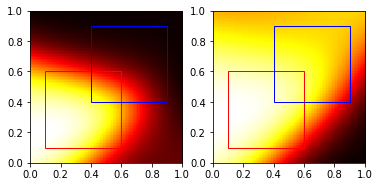

In [8]:
draw_classes(model, draw=(lambda ax, i: draw_rectangles(ax, rect0, rect1)))